In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cbct-liver-and-liver-tumor-segmentation-train-data/TRAINCTAlignedToCBCT/volume-100.nii
/kaggle/input/cbct-liver-and-liver-tumor-segmentation-train-data/TRAINCTAlignedToCBCT/volume-47.nii
/kaggle/input/cbct-liver-and-liver-tumor-segmentation-train-data/TRAINCTAlignedToCBCT/volume-12.nii
/kaggle/input/cbct-liver-and-liver-tumor-segmentation-train-data/TRAINCTAlignedToCBCT/volume-3.nii
/kaggle/input/cbct-liver-and-liver-tumor-segmentation-train-data/TRAINCTAlignedToCBCT/volume-34.nii
/kaggle/input/cbct-liver-and-liver-tumor-segmentation-train-data/TRAINCTAlignedToCBCT/volume-54.nii
/kaggle/input/cbct-liver-and-liver-tumor-segmentation-train-data/TRAINCTAlignedToCBCT/volume-8.nii
/kaggle/input/cbct-liver-and-liver-tumor-segmentation-train-data/TRAINCTAlignedToCBCT/volume-57.nii
/kaggle/input/cbct-liver-and-liver-tumor-segmentation-train-data/TRAINCTAlignedToCBCT/volume-26.nii
/kaggle/input/cbct-liver-and-liver-tumor-segmentation-train-data/TRAINCTAlignedToCBCT/volume-63.nii
/

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os


In [3]:
!pip install nibabel


In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import nibabel as nib

# Define paths
cbct_dir = "/kaggle/input/cbct-liver-and-liver-tumor-segmentation-train-data/TRAINCBCTSimulated"
ct_dir = "/kaggle/input/cbct-liver-and-liver-tumor-segmentation-train-data/TRAINCTAlignedToCBCT"

# Function to extract IDs from filenames
def extract_id(filename):
    return ''.join(filter(str.isdigit, filename))

# Extract IDs and filter files
cbct_files = {}
for root, dirs, files in os.walk(cbct_dir):
    for file in files:
        if file.endswith('.nii'):
            cbct_files[extract_id(file)] = os.path.join(root, file)

ct_files = {}
for root, dirs, files in os.walk(ct_dir):
    for file in files:
        if file.endswith('.nii'):
            ct_files[extract_id(file)] = os.path.join(root, file)

# Align CBCT and CT files based on IDs
aligned_pairs = [(cbct_files[id], ct_files[id]) for id in cbct_files if id in ct_files]
print(f"Aligned {len(aligned_pairs)} CBCT-CT pairs.")

# Load data
def load_data(cbct_path, ct_path):
    cbct = nib.load(cbct_path).get_fdata()
    cbct = tf.convert_to_tensor(cbct, dtype=tf.float32)
    
    ct = nib.load(ct_path).get_fdata()
    ct = tf.convert_to_tensor(ct, dtype=tf.float32)
    
    return cbct, ct

# Load and preprocess data
train_cbct = []
train_ct = []
for cbct_path, ct_path in aligned_pairs:
    cbct, ct = load_data(cbct_path, ct_path)
    
    # Select a middle slice for demonstration
    cbct_slice = cbct[:, :, cbct.shape[2]//2]
    ct_slice = ct[:, :, ct.shape[2]//2]
    
    # Add channel dimension
    cbct_slice = cbct_slice[tf.newaxis, ..., tf.newaxis]
    ct_slice = ct_slice[tf.newaxis, ..., tf.newaxis]
    
    # Resize images to a common size if necessary
    cbct_resized = tf.image.resize(cbct_slice, (256, 256))
    ct_resized = tf.image.resize(ct_slice, (256, 256))
    
    train_cbct.append(cbct_resized[0])
    train_ct.append(ct_resized[0])

# Convert lists to tensors
train_cbct = tf.stack(train_cbct)
train_ct = tf.stack(train_ct)

# Normalize data
train_cbct = train_cbct / tf.reduce_max(train_cbct)
train_ct = train_ct / tf.reduce_max(train_ct)

# Rest of your code for U-Net or any other model...


Aligned 131 CBCT-CT pairs.


In [5]:
# Define the U-Net model
def define_unet(input_shape):
    inputs = keras.Input(shape=input_shape)
    
    # Encoder
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)
    
    # Bottleneck
    conv5 = layers.Conv2D(512, (2, 2), activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(512, (2, 2), activation='relu', padding='same')(conv5)
    
    # Decoder
    up6 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5)
    merge6 = layers.Concatenate()([conv4, up6])
    conv6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(merge6)
    conv6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    
    up7 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6)
    merge7 = layers.Concatenate()([conv3, up7])
    conv7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(merge7)
    conv7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    
    up8 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)
    merge8 = layers.Concatenate()([conv2, up8])
    conv8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(merge8)
    conv8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    
    up9 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8)
    merge9 = layers.Concatenate()([conv1, up9])
    conv9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(merge9)
    conv9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    
    outputs = layers.Conv2D(1, (3, 3), activation='tanh', padding='same')(conv9)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Define input shape
input_shape = (256, 256, 1)

# Create model
unet = define_unet(input_shape)
unet.compile(optimizer='adam', loss='mean_squared_error')


In [6]:
# Train the model
batch_size = 32
epochs = 100

for epoch in range(epochs):
    for i in range(len(train_cbct) // batch_size):
        cbct_batch = train_cbct[i*batch_size:(i+1)*batch_size]
        ct_batch = train_ct[i*batch_size:(i+1)*batch_size]
        
        # Train U-Net
        loss = unet.train_on_batch(cbct_batch, ct_batch)
        
    print(f"Epoch {epoch+1}, Loss: {loss}")


Epoch 1, Loss: 0.028880568221211433
Epoch 2, Loss: 0.027430716902017593
Epoch 3, Loss: 0.02422485500574112
Epoch 4, Loss: 0.021750949323177338
Epoch 5, Loss: 0.01971999928355217
Epoch 6, Loss: 0.018206218257546425
Epoch 7, Loss: 0.01704142428934574
Epoch 8, Loss: 0.016120539978146553
Epoch 9, Loss: 0.015416443347930908
Epoch 10, Loss: 0.014825413003563881
Epoch 11, Loss: 0.014337488450109959
Epoch 12, Loss: 0.013907509855926037
Epoch 13, Loss: 0.013521790504455566
Epoch 14, Loss: 0.013529926538467407
Epoch 15, Loss: 0.013479858636856079
Epoch 16, Loss: 0.01332992222160101
Epoch 17, Loss: 0.013116658665239811
Epoch 18, Loss: 0.01292097195982933
Epoch 19, Loss: 0.012727072462439537
Epoch 20, Loss: 0.01255030743777752
Epoch 21, Loss: 0.01238506194204092
Epoch 22, Loss: 0.012229720130562782
Epoch 23, Loss: 0.012082981877028942
Epoch 24, Loss: 0.011942795477807522
Epoch 25, Loss: 0.011810787953436375
Epoch 26, Loss: 0.011686454527080059
Epoch 27, Loss: 0.011538725346326828
Epoch 28, Loss: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


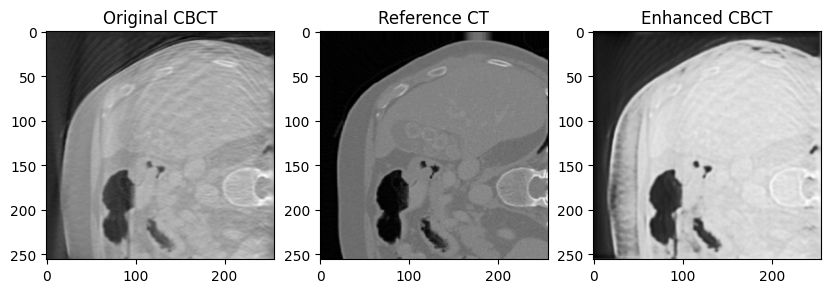

In [7]:
# Use the trained model to enhance CBCT images
def enhance_cbct(cbct_image):
    enhanced_image = unet.predict(cbct_image)  # Remove the extra tf.newaxis
    return enhanced_image[0]

# Example usage
example_cbct = train_cbct[0][tf.newaxis, ...]  # This already adds a batch dimension
enhanced_example = enhance_cbct(example_cbct)

# Display results
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(example_cbct[0, :, :, 0], cmap='gray')
plt.title('Original CBCT')
plt.subplot(1, 3, 2)
plt.imshow(train_ct[0, :, :, 0], cmap='gray')
plt.title('Reference CT')
plt.subplot(1, 3, 3)
plt.imshow(enhanced_example[:, :, 0], cmap='gray')
plt.title('Enhanced CBCT')
plt.show()


In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.metrics import structural_similarity as ssim

# Assuming you have the enhanced images and reference images
def calculate_psnr(enhanced_image, reference_image):
    mse = np.mean((enhanced_image - reference_image) ** 2)
    max_pixel_value = 1.0  # Assuming normalized images
    psnr = 10 * np.log10((max_pixel_value ** 2) / mse)
    return psnr

def calculate_ssim(enhanced_image, reference_image):
    # Ensure both are 2D arrays
    enhanced_image = np.squeeze(enhanced_image)
    reference_image = np.squeeze(reference_image)
    
    # Calculate SSIM
    ssim_value = ssim(enhanced_image, reference_image, data_range=1.0)
    return ssim_value

def calculate_mse(enhanced_image, reference_image):
    mse = np.mean((enhanced_image - reference_image) ** 2)
    return mse

def calculate_rmse(enhanced_image, reference_image):
    rmse = np.sqrt(np.mean((enhanced_image - reference_image) ** 2))
    return rmse

# Example usage
example_cbct = train_cbct[0][tf.newaxis, ...]
enhanced_example = unet.predict(example_cbct)

# Convert to NumPy arrays if necessary (already NumPy in your case)
enhanced_example = np.squeeze(enhanced_example)
reference_image = np.squeeze(train_ct[0][tf.newaxis, ...])

psnr = calculate_psnr(enhanced_example, reference_image)
ssim = calculate_ssim(enhanced_example, reference_image)
mse = calculate_mse(enhanced_example, reference_image)
rmse = calculate_rmse(enhanced_example, reference_image)

print(f"PSNR: {psnr}, SSIM: {ssim}, MSE: {mse}, RMSE: {rmse}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
PSNR: 27.263500507787086, SSIM: 0.5222113286460505, MSE: 0.0018778026569634676, RMSE: 0.043333619832992554
